# II. Graph convolutional networks

In this notebook, we'll show how to build graph convolutional networks (GCNs) 
using the differential structures exposed by `topos`. 

In [6]:
import torch
import topos
import matplotlib.pyplot as plt

## 1. Graphs and complexes

In the following, we denote by $\Omega = \{1, \dots, N_{\rm vtx}\}$ a finite set 
of vertices. 

A 1-graph $G$ is usually defined by a set of edges contained in 
$\Omega \times \Omega$ with set of vertices is $\Omega$ 
i.e. the boundary of every edge is a vertex of the graph.
This is a particular case of simplicial complex (dimension 1), and the 
reason why we shall use the `Complex` class. 

__Definition 1.__
A _simplicial complex_ $K \subset {\mathcal P}(\Omega)$ is a collection of regions 
such that for all $a \in K$, every $b \subset a$ is also in $K$.
The _dimension_ of $K$ is one plus the maximal size of regions $a \in K$, also called _faces_ of $K$. 


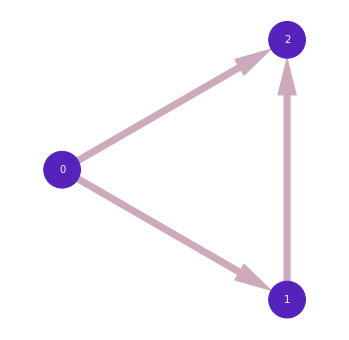

In [7]:
""" Creation of 1D complexes """

from topos import Complex

#-- Complex constructor: ensure to provide all vertices! --
G = Complex([[0, 1, 2], [[0, 1], [0, 2], [1, 2]]])

#-- Simplicial closure : subfaces i.e. vertices are computed --
G = Complex.simplicial([[0, 1], [0, 2], [1, 2]])

fig = topos.io.plot_graph(G, size=(6, 6))

The sets of vertices and edges can be accessed by `G[0]` and `G[1]` respectively. They are implemented as `Sheaf` instances, as we shall discuss in the next section.

Let us for now briefly review the different `Field` types associated to $G, G_0$ and $G_1$. Fields are scalar valued functions on their domains, i.e. vectors of dimension `field.domain.size`. The type constructor is obtained by wrapping `torch.Tensor` types inside a custom Wrap monad
(see [fp.Tens](https://github.com/opeltre/fp/blob/master/fp/instances/tens.py)).
Field types will further allow us to define a type for linear maps from $G$-fields to $G'$-fields, etc.

In [8]:
""" Field types """

from topos import Field

assert isinstance(Field(G), type)

#----- G.Field(degree=None) ------
assert G.Field()  == Field(G)
assert G.Field(0) == Field(G[0])
assert G.Field(1) == G[1].Field()

assert isinstance(G.randn(0), G.Field(0))
Field

Functor : Field

A `Field(G)` instance of particular interest to understand the data structure is `G.range()`: its wrapped vector attribute coincides with `torch.arange(G.size)` and therefore maps every point of the domain to its index in `G`.

In [9]:
""" Field creation """

#-- Index map on G --
x = G.range()

#-- Index map on G[0]
x0 = G.range(0)

#-- Index map on G[1]
x1 = G[1].range()

#-- x = x0 | x1 + G.begin[1] | ... --
assert (x0.data == x.data[:G.begin[1]]).prod()
assert (x1.data == x.data[G.begin[1]:] - G.begin[1]).prod()
x

Field G :  0 :  [0] :        0
                [1] :        1
                [2] :        2
               
           1 :  [0, 1] :        3
                [0, 2] :        4
                [1, 2] :        5
               
          

For now fields are only scalar-valued functions on the sets of edges and vertices. It is more interesting to allow for arbitrary numbers of vertex and edge features. This is what we'll introduce in section I.3. 

Let us first remind elementary notions from differential calculus on simplicial complexes. 

## 2. Differential Calculus

## 3. Functor values

There are many possible ways one may assign degrees of freedom to regions. To build vanilla GCNs, we may assume that edges and vertices all have the same degrees of freedom, i.e. fibers $F_i$, $F_j$, $F_{ij}$, ... are all isomorphic 
to a common finite set $F$.

To compute the differential $d$ and codifferential $\delta$ in a functor-valued graph, it is required that:
- either edge features $F_{ij}$ can be mapped to vertex features $F_i, F_j$
- either vertex features $F_i, F_j$ can be mapped to edge features $F_{ij}$ 

The `ConstantFunctor` subclass will yield a single object $F$ and identity arrows. 
It is in practice equivalent to:


In [10]:
""" Constant feature spaces """

def ConstantFunctor(shape):
    """ Single shape interpreted as a finite set + identities """        
    #----- topos.Functor(obj_map, hom_map)
    return topos.Functor(lambda _: shape, lambda _: lambda x: x)

The `Complex` constructor accepts an optional `functor` second argument.
Note how index ranges have been expanded. 

In [11]:
""" Functor valued complex """

F  = ConstantFunctor([3])
GF = Complex(G, F)

GF.range()

Field G :  0 :  [0] :        [0, 1, 2]
                [1] :        [3, 4, 5]
                [2] :        [6, 7, 8]
               
           1 :  [0, 1] :        [ 9, 10, 11]
                [0, 2] :        [12, 13, 14]
                [1, 2] :        [15, 16, 17]
               
          

With a constant functor, the differential and codifferential will simply add and subtract field components feature-wise, e.g.

In [12]:
""" Functor-valued differential """

GF.diff(0) @ GF.range(0)

Field F(Ω) :  [0, 1] :        [3., 3., 3.]
              [0, 2] :        [6., 6., 6.]
              [1, 2] :        [3., 3., 3.]
             

In [13]:
""" Functor-valued codifferential """

GF.codiff(1) @ GF.ones(1)

Field F(Ω) :  [0] :        [-2., -2., -2.]
              [1] :        [0., 0., 0.]
              [2] :        [2., 2., 2.]
             

We are now ready to design convolutional filters on arbitrary graphs 
by combining local features transformations with powers of the laplacian.

## 4. Convolutional Filters 

The graph Laplacian $L$ is obtained by composing the differential and codifferential, i.e. in degree 0 (functions on vertices):
$$ L = \delta \circ d $$
When using a constant functor of dimension $n_F$, and denoting by $n_0$ the number of vertices, the space of $0$-fields is naturally isomorphic to $\mathbb{R}^{n_F \times n_0} \simeq \mathbb{R}^{n_F} \otimes \mathbb{R}^{n_0}$ (note that vertex features are stored contiguously in memory). 

Therefore we may compose the Laplacian (or powers of the latter) with feature matrices $W \in \mathbb{R}^{n_F \times n_F}$ to yield so-called _graph convolutional filters_:
$$ P_{\bar W}[L] = \sum_{k=0}^{|\bar W|} W_k \otimes L^{k} $$

The most natural way to implement this would be via an all-purpose _tensor product_ of operators represented by sparse matrices. 

However, for illustration purposes we propose the `torch.nn.Module` subclass below, using tensor reshapes in its `forward` method.

In [34]:
from torch import nn

class GCN (nn.Module):
    """ 
    Convolutional filters with possibly different input and output dims.
    """
    def __init__(self, graph, weights):
        """
        Inputs:
            - graph:    scalar valued graph with n0 vertices
            - weights:  [deg_w, dim_in, dim_out] tensor

        Output:
            - [dim_out * n_0, dim_in * n_0] tensor
        """
        super().__init__()
        # Polynomial coefficients
        self.range        = weights.shape[0]
        self.out_features = weights.shape[1]
        self.in_features  = weights.shape[2]
        self.weights = weights
        # Graph Laplacian 
        self.graph = graph
        self.Nvtx = graph.Nvtx
        L = graph.codiff(1) @ graph.diff(0)
        self.powers_L = [L]
        for k in range(self.range - 1):
            pow_L = self.powers_L[-1]
            self.powers_L.append(pow_L @ L)
        self.powers_L = [pow_L.data for pow_L in self.powers_L]
    
    def forward(self, x):
        """
        Action on a (flattened) [n_batch, Nvtx * in_features] tensor.
        """
        n_batch = x.shape[0]
        # Vertex dimension first
        x = x.T.reshape([self.Nvtx, self.in_features * n_batch])
        Lx = [pow_L @ x for pow_L in self.powers_L]
        # Feature dimension first
        Lx = [(y.view([self.Nvtx, self.in_features, n_batch])
                .transpose(0, 1)
                .reshape([self.in_features, self.Nvtx * n_batch]))\
                for y in Lx]
        WLx = [W @ y for W, y in zip(self.weights, Lx)]
        # Sum monomials 
        out = torch.stack(WLx).sum([0])
        # Output shape
        out = (out.view([self.out_features, self.Nvtx, n_batch])
                  .transpose(0, 2)
                  .reshape([n_batch, self.Nvtx * self.out_features]))
        return out                  

The above implementation, although not very elegant, shows how `topos` geometric instances can interact with usual `torch` operations and modules.

Let's see it in action on our simple example:

In [38]:
# range 2, output features 6, input features 3
W = torch.randn([2, 6, 3])

filter = GCN(G, W)

# batched input 
x = torch.stack([GF.randn(0).data for i in range(10)])
y = filter(x)
print(f'ouput shape: {y.shape}')

# first field instance
Gout = Complex(G, ConstantFunctor([6]))
y0 = Gout.field(y[0], 0)
y0


ouput shape: torch.Size([10, 18])


Field F(Ω) :  [0] :        [ -7.1912,  32.8649,  -0.9744, -22.5302,  19.3923, -17.5181]
              [1] :        [ 16.2049, -19.4454,  -7.2308,   4.6212, -11.0392,  12.1334]
              [2] :        [ -9.0137, -13.4194,   8.2052,  17.9089,  -8.3532,   5.3847]
             